In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import logging

from inference import infer_tool
from inference.infer_tool import Svc
import torch

from IPython.display import Audio
from IPython.display import display
import utils
import random
import torchaudio

logging.getLogger("numba").setLevel(logging.WARNING)
chunks_dict = infer_tool.read_temp("inference/chunks_temp.json")


feature_retrieval = True


sovits_model_path = "/home/cfm-vc/logs/cfm_model/G_ema_104000.pth"
sovits_config_path = "/home/cfm-vc/logs/cfm_model/config.json"

device = "cpu"

svc_model = Svc(
    net_g_path=sovits_model_path,
    config_path=sovits_config_path,
    device=device,
)


hps = utils.get_hparams_from_file(sovits_config_path, True)

speaker_files = {}

with open("/workspace/vocoder_train.csv", "r") as rf:
    for line in rf:
        wav_path, speaker_name = line.split("|")
        speaker_name = speaker_name.strip()

        if speaker_name not in speaker_files:
            speaker_files[speaker_name] = []

        speaker_files[speaker_name].append(wav_path)


def inference(
    raw_audio_path,
    target_audio_path,
    cluster_infer_ratio=0.0,
    n_timesteps=2,
    guidance_scale=0.0,
    temperature=1.0,
    f0_predictor="rmpve",
    solver="euler",
):
    trans = 0
    f0_filter_threshold = 0.05

    infer_tool.mkdir(["raw", "results"])

    infer_tool.format_wav(raw_audio_path)
    for target_wav in target_audio_path:
        infer_tool.format_wav(target_wav)

    kwarg = {
        "raw_audio_path": raw_audio_path,
        "raw_target_audio_path": target_audio_path,
        "tran": trans,
        "cluster_infer_ratio": cluster_infer_ratio,
        "n_timesteps": n_timesteps,
        "f0_predictor": f0_predictor,
        "cr_threshold": f0_filter_threshold,
        "temperature": temperature,
        "guidance_scale": guidance_scale,
        "solver": solver,
    }
    mel = svc_model.slice_inference(**kwarg)

    return mel

Using DiT
load 
load model(s) from /workspace/pretrained_models/checkpoint_best_legacy_500.pt
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")



In [2]:
from vdecoder.IstftGenerator.model import Generator
from vdecoder.utils import AttrDict
from modules.denoiser import Denoiser

import json


model_file = "/workspace/pretrained_models/Vocoder/g_00595000"
config_file = "/workspace/pretrained_models/Vocoder/config.json"
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)

generator = Generator(h).to(device)

checkpoint_dict = torch.load(model_file, map_location=device)
generator.load_state_dict(checkpoint_dict["generator"])

generator.eval()
generator.remove_weight_norm()

Removing weight norm...


In [5]:
import time

source_audio = "/workspace/samples/Jorgenson.wav"
target_speaker = "Xardas_g2"
target_audios = speaker_files[target_speaker]
target_audios = random.sample(target_audios, len(target_audios[:10]))


print("Speaker:", target_speaker)
print("Source Audio:")
display(Audio(source_audio, rate=svc_model.target_sample, autoplay=False))
print(f"Target Audio ({len(target_audios)})")
display(Audio(target_audios[0], rate=svc_model.target_sample, autoplay=False))

start_time = time.time()

mel = inference(
    source_audio,
    target_audios,
    f0_predictor="rmvpe",
    cluster_infer_ratio=0.5,
    n_timesteps=16,
    temperature=1.0,
    guidance_scale=0.5,
    solver="midpoint",
)

print(f"VC Time: {time.time() - start_time}")

start_time = time.time()


audio = generator(mel)  # .squeeze(0).data.cpu().float().numpy()

print(f"Decoder Time: {time.time() - start_time}")


# soundfile.write(
#     f"/home/alexander/Projekte/so-vits-svc/raw/{target_speaker.lower()}.wav",
#     audio,
#     44100,
#     format="WAV",
#     subtype="PCM_16",
# )

audio = (
    torchaudio.functional.resample(audio, 22050, 44100)
    .squeeze(0)
    .data.cpu()
    .float()
    .numpy()
)
display(Audio(audio, rate=44100, autoplay=False))

Speaker: Xardas_g2
Source Audio:


Target Audio (10)


VC Time: 9.085922956466675
Decoder Time: 0.9244275093078613


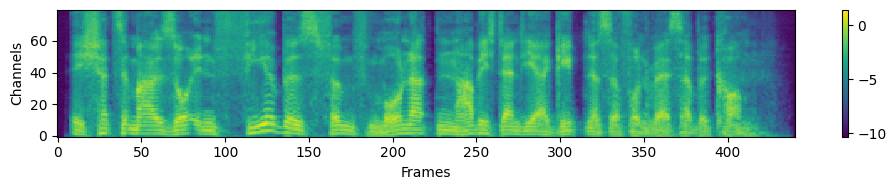

In [7]:
utils.plot_spectrogram_to_numpy(mel[0].cpu().numpy(), return_figure=True)[1]

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from modules.mel_processing import mel_spectrogram_torch
import utils
import torchaudio

audio, sr = torchaudio.load(source_audio)
mel_gen = mel_spectrogram_torch(audio, 1024, 80, 22050, 256, 1024, 0, 8000)
utils.plot_spectrogram_to_numpy(mel_gen[0].cpu().numpy(), return_figure=True)[1]

audio = generator(mel_gen).squeeze(0).data.cpu().float().numpy()
display(Audio(audio, rate=22050, autoplay=False))

## Testing

In [ ]:
augmented_audio = torch.from_numpy(audio)
mel = mel_spectrogram_torch(augmented_audio, 2048, 80, 44100, 512, 2048, 0, 11000)
utils.plot_spectrogram_to_numpy(mel[0].cpu().numpy(), return_figure=True)[1]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FeatureShiftModel(nn.Module):
    def __init__(
        self, feature_dim=192, num_latents=32, cluster_infer_ratio=0.5, latent_dim=128
    ):
        super(FeatureShiftModel, self).__init__()
        self.feature_dim = feature_dim
        self.num_latents = num_latents
        self.cluster_infer_ratio = cluster_infer_ratio
        self.latent_dim = latent_dim

        # Encoder: Source features to latent space
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, latent_dim),
        )

        # Decoder: Latent space (combined with target latents) to shifted features
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + feature_dim, feature_dim),  # Assuming concatenation
            nn.LeakyReLU(0.2),
            nn.Linear(feature_dim, feature_dim),
        )

    def forward(self, source_features, target_latents):
        # Encode source features
        # Assuming source_features is of shape (batch, feature_dim, sequence_length)
        # Need to permute to apply linear layer: (batch, sequence_length, feature_dim)
        source_features_permuted = source_features.permute(0, 2, 1)
        encoded_features = self.encoder(source_features_permuted)

        # Aggregate target latents
        aggregated_target_latents = target_latents.mean(dim=2, keepdim=True)
        expanded_target_latents = aggregated_target_latents.expand(
            -1, -1, source_features.shape[2]
        )

        # Combine encoded source features with target latents
        # For simplicity, we concatenate along the feature dimension
        combined = torch.cat(
            (encoded_features, expanded_target_latents.permute(0, 2, 1)), dim=-1
        )

        # Decode the combined representation to get shifted features
        shifted_features = self.decoder(combined)

        shifted_features = shifted_features.permute(
            0, 2, 1
        )  # Permute back to original shape

        # Combine decoded features with original source features (optional)
        shifted_features = (
            self.cluster_infer_ratio * shifted_features
            + (1 - self.cluster_infer_ratio) * source_features
        )

        return shifted_features


# Example usage
batch_size = 4
sequence_length = 182
cluster_infer_ratio = 0.5

model = FeatureShiftModel(
    feature_dim=192,
    num_latents=32,
    cluster_infer_ratio=cluster_infer_ratio,
    latent_dim=128,
)
source_features = torch.randn(batch_size, 192, sequence_length)
target_latents = torch.randn(batch_size, 192, 32)  # Target latents

shifted_features = model(source_features, target_latents)
print(shifted_features.shape)  # Expected shape: (batch, 192, sequence length)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import modules.attentions as attentions
from modules.feature_encoder_decoder import FeatureEncoderDecoder

# Example usage
batch_size = 4
sequence_length = 182

model = FeatureEncoderDecoder(hidden_channels=192)
x = torch.randn(batch_size, 192, sequence_length)  # Adjusted shape for LSTM
x_mask = torch.ones(batch_size, 1, sequence_length)
prosody_latent = torch.randn(batch_size, 192, 32)  # Target latents
prosody_mask = torch.ones(batch_size, 1, 32)

shifted_features = model(
    x, x_mask, prosody_latent, prosody_mask
)  # Transpose back to original shape
print(shifted_features.shape)  # Expected shape: (batch, sequence_length, 192)